# Ginkgo full data

In [1]:

import pyprob
import numpy as np
import ot
import torch
import cProfile
import pickle

from pyprob.dis import ModelDIS
from showerSim import invMass_ginkgo
from torch.utils.data import DataLoader
from pyprob.nn.dataset import OnlineDataset
from pyprob.util import InferenceEngine
from pyprob.util import to_tensor
from pyprob import Model
import math
from pyprob.distributions import Normal
from pyprob.distributions.delta import Delta


import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as mpl_cm
plt.ion()

from sbi import utils
from sbi import analysis
from sbi.inference.base import infer
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi.utils.get_nn_models import posterior_nn


import sklearn as skl
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
from joblib import Parallel, delayed
from torch.nn.functional import pad

from geomloss import SamplesLoss
sinkhorn = SamplesLoss(loss="sinkhorn", p=1, blur=.05)
def sinkhorn_t(x,y):
    x = torch.as_tensor(x)
    y = torch.as_tensor(y)
    return sinkhorn(x,y)

def ot_dist(x,y):
    x = x.detach().numpy()
    y = y.detach().numpy()
    a = ot.unif(len(x))
    b = ot.unif(len(y))
    Mat = ot.dist(x, y, metric='euclidean')
    distance = torch.tensor(ot.emd2(a,b,Mat))
    return distance

[pyKeOps]: Warning, no cuda detected. Switching to cpu only.


In [2]:
## Prepare functions
QCD_mass = to_tensor(30.)
#rate=to_tensor([QCD_rate,QCD_rate]) #Entries: [root node, every other node] decaying rates. Choose same values for a QCD jet
jetdir = to_tensor([1.,1.,1.])
jetP = to_tensor(400.)
jetvec = jetP * jetdir / torch.linalg.norm(jetdir) ## Jetvec is 3-momentum. JetP is relativistic p.


# Actual parameters
pt_min = to_tensor(0.3**2)
M2start = to_tensor(QCD_mass**2)
jetM = torch.sqrt(M2start) ## Mass of initial jet
jet4vec = torch.cat((torch.sqrt(jetP**2 + jetM**2).reshape(-1), jetvec))
minLeaves = 1
maxLeaves = 10000 # unachievable, to prevent rejections
maxNTry = 100


ginkgo_simulator = invMass_ginkgo.SimulatorModel(jet_p=jet4vec,  # parent particle 4-vector
                                    pt_cut=float(pt_min),  # minimum pT for resulting jet
                                    Delta_0= M2start,  # parent particle mass squared -> needs tensor
                                    M_hard=jetM,  # parent particle mass
                                    minLeaves=1,  # minimum number of jet constituents
                                    maxLeaves=50,  # maximum number of jet constituents (a large value to stop expensive simulator runs)
                                    suppress_output=True)

prior_min = [1e-3,1e-3]
prior_max = [30.,30.]
prior_full = utils.torchutils.BoxUniform(low=torch.as_tensor(prior_min), 
                                    high=torch.as_tensor(prior_max))

In [3]:
def flatten_data(leaves, sort = False):

    if sort:
        flattened = leaves[leaves[:, 0].sort()[1]].reshape(-1)
    else:
        flattened=leaves.reshape(-1)
    
    length = len(flattened)

    if length == 200:
        return flattened
    else:
        pad_length = 200 - length
        return pad(flattened,(0,pad_length))
    

## Simulator

In [6]:
def simulator_wrapper_sorted(params):   
    leaves = ginkgo_simulator(params)['leaves']
    return flatten_data(leaves, sort = True)

def simulator_wrapper_unsorted(params):   
    leaves = ginkgo_simulator(params)['leaves']
    return flatten_data(leaves, sort = False)

In [7]:
ref_obs33 = simulator_wrapper_sorted([3,3])
ref_obs153 = simulator_wrapper_sorted([15,3])
ref_obs1010 = simulator_wrapper_sorted([10,10])

## Inference

In [9]:
posterior = infer(simulator_wrapper_sorted, prior_full, method='SNPE', num_simulations=5000,num_workers=7)

Running 5000 simulations in 5000 batches.:   0%|          | 0/5000 [00:00<?, ?it/s]

[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
 Neural network successfully converged after 37 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

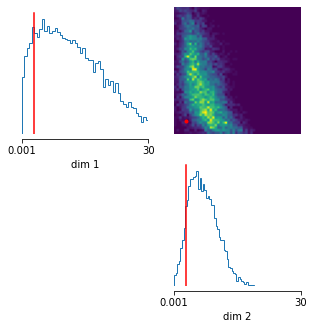

In [11]:
samples = posterior.sample((10000,),x=ref_obs33)
fig, axes = analysis.pairplot(samples,
                        limits=[[1e-3,30.], [1e-3,30.]],
                        ticks=[[1e-3,30.], [1e-3,30.]],
                        figsize=(5,5),
                        points=np.array([3,3]),
                        points_offdiag={'markersize': 6},
                        points_colors='r');
plt.show()

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

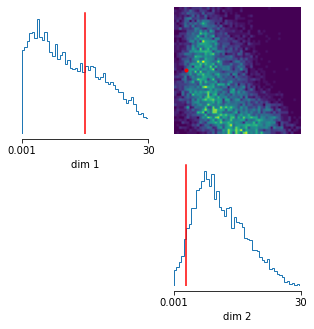

In [14]:
samples = posterior.sample((10000,),x=ref_obs153)
fig, axes = analysis.pairplot(samples,
                        limits=[[1e-3,30.], [1e-3,30.]],
                        ticks=[[1e-3,30.], [1e-3,30.]],
                        figsize=(5,5),
                        points=np.array([15,3]),
                        points_offdiag={'markersize': 6},
                        points_colors='r');
plt.show()

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

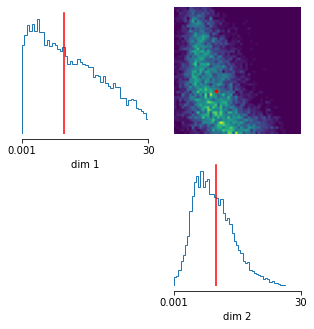

In [16]:
samples = posterior.sample((10000,),x=ref_obs1010)
fig, axes = analysis.pairplot(samples,
                        limits=[[1e-3,30.], [1e-3,30.]],
                        ticks=[[1e-3,30.], [1e-3,30.]],
                        figsize=(5,5),
                        points=np.array([10,10]),
                        points_offdiag={'markersize': 6},
                        points_colors='r');
plt.show()

## Multi-round inference

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
 Neural network successfully converged after 41 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 27 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 28 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 29 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 22 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

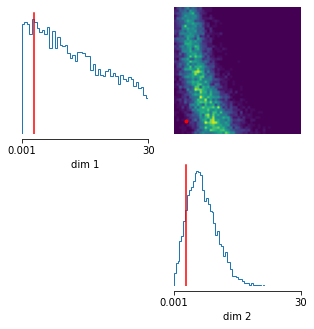

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 36 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 23 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 27 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 22 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 21 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

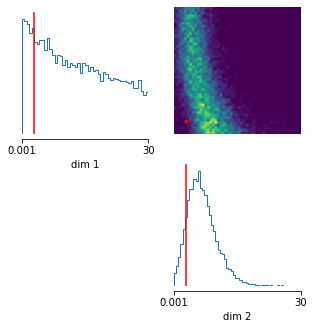

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 25 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 21 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 22 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 37 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

[pyKeOps]: Warning, no cuda detected. Switching to cpu only.[pyKeOps]: Warning, no cuda detected. Switching to cpu only.[pyKeOps]: Warning, no cuda detected. Switching to cpu only.


[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
Using SNPE-C with atomic loss
 Neural network successfully converged after 21 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

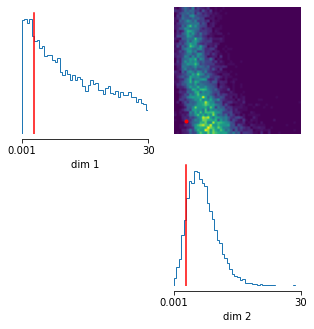

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
Using SNPE-C with atomic loss
 Neural network successfully converged after 21 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
Using SNPE-C with atomic loss
 Neural network successfully converged after 21 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
Using SNPE-C with atomic loss
 Neural network successfully converged after 24 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
Using SNPE-C with atomic loss
 Neural network successfully converged after 21 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
Using SNPE-C with atomic loss
 Neural network successfully converged after 23 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

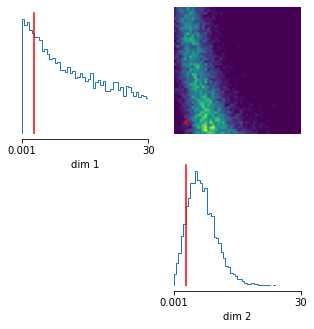

In [20]:
num_rounds = 20
posteriors = []
simulator, prior = prepare_for_sbi(simulator_wrapper_sorted, prior_full)
proposal = prior
inference = SNPE(prior=prior)
for i in range(num_rounds):
    theta, x = simulate_for_sbi(simulator, proposal, num_simulations=2000, num_workers=7)
    density_estimator = inference.append_simulations(theta, x, proposal=proposal).train()
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    proposal = posterior.set_default_x(ref_obs33)
    samples = posterior.sample((10000,))
    if (i+1)%5==0:
        fig, axes = analysis.pairplot(samples,
                                limits=[[1e-3,30.], [1e-3,30.]],
                                ticks=[[1e-3,30.], [1e-3,30.]],
                                figsize=(5,5),
                                points=np.array([3,3]),
                                points_offdiag={'markersize': 6},
                                points_colors='r');
        plt.show()

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
 Neural network successfully converged after 39 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 26 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 38 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 26 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 28 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

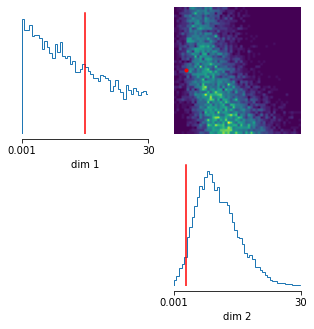

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 5

KeyboardInterrupt: 

In [21]:
num_rounds = 20
posteriors = []
simulator, prior = prepare_for_sbi(simulator_wrapper_sorted, prior_full)
proposal = prior
inference = SNPE(prior=prior)
for i in range(num_rounds):
    theta, x = simulate_for_sbi(simulator, proposal, num_simulations=2000, num_workers=7)
    density_estimator = inference.append_simulations(theta, x, proposal=proposal).train()
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    proposal = posterior.set_default_x(ref_obs153)
    samples = posterior.sample((10000,))
    if (i+1)%5==0:
        fig, axes = analysis.pairplot(samples,
                                limits=[[1e-3,30.], [1e-3,30.]],
                                ticks=[[1e-3,30.], [1e-3,30.]],
                                figsize=(5,5),
                                points=np.array([15,3]),
                                points_offdiag={'markersize': 6},
                                points_colors='r');
        plt.show()

# Roughs

In [17]:
len(flatten_data(ginkgo_simulator([3,3])['leaves'].reshape(-1)))

200

In [18]:
test_leaves = ginkgo_simulator([3,3])['leaves']

In [26]:
test_leaves[test_leaves[:, 0].sort()[1]]


tensor([[ 0.2789,  0.1414,  0.1810,  0.1582],
        [ 0.9076,  0.4125,  0.5850,  0.5534],
        [ 0.9416,  0.5015,  0.6067,  0.4438],
        [ 1.2232,  0.6111,  0.8521,  0.6269],
        [ 2.1186,  0.9789,  1.2047,  1.4282],
        [ 2.6179,  1.0893,  1.5385,  1.8006],
        [ 3.1777,  1.7652,  2.0254,  1.6927],
        [ 3.4298,  1.9552,  1.9899,  1.9951],
        [ 3.4588,  1.8966,  2.0025,  2.0776],
        [ 3.6592,  2.1180,  2.1504,  2.0674],
        [ 4.5140,  2.7996,  2.3537,  2.6378],
        [ 4.5896,  2.4661,  2.5872,  2.8732],
        [ 5.9195,  3.2004,  3.4188,  3.6194],
        [ 6.3058,  3.8020,  3.4213,  3.6862],
        [ 6.6549,  3.9459,  3.5146,  4.0448],
        [ 6.6765,  3.5517,  4.4070,  3.5363],
        [ 6.9244,  4.0057,  3.8102,  4.1593],
        [ 7.0040,  3.5627,  3.6014,  4.8296],
        [ 7.2273,  3.9259,  4.1781,  4.4006],
        [ 7.2611,  4.0261,  4.1861,  4.3527],
        [ 8.0587,  5.4537,  4.4847,  3.8814],
        [ 8.1278,  4.5623,  4.9039